In [1]:
!pip install scikit-plot

In [2]:
!pip3 install catboost

     |████████████████████████████████| 67.4 MB 30 kB/s 


In [3]:
!pip install xgbfir

     |████████████████████████████████| 148 kB 4.1 MB/s 


In [4]:
!pip install eli5

     |████████████████████████████████| 106 kB 4.0 MB/s 


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import scikitplot as skplt
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import catboost as ctb
from scikitplot.estimators import plot_learning_curve

from collections import Counter

from sklearn import utils
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold,  GroupKFold, cross_val_score, cross_validate, cross_val_predict
from scikitplot.metrics import plot_confusion_matrix, plot_calibration_curve

import gc
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
from collections import defaultdict

import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from keras.models import load_model, Model

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
cd '/content/drive/My Drive/Konkursy Kaggle/Titanic'

/content/drive/My Drive/Konkursy Kaggle/Titanic


In [101]:
train = pd.read_csv('/content/drive/My Drive/Konkursy Kaggle/Titanic/train.csv').reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/Konkursy Kaggle/Titanic/test.csv').reset_index(drop=True)
gender = pd.read_csv('/content/drive/My Drive/Konkursy Kaggle/Titanic/gender_submission.csv').reset_index(drop=True)

**Familiarize with data**

In [102]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [103]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


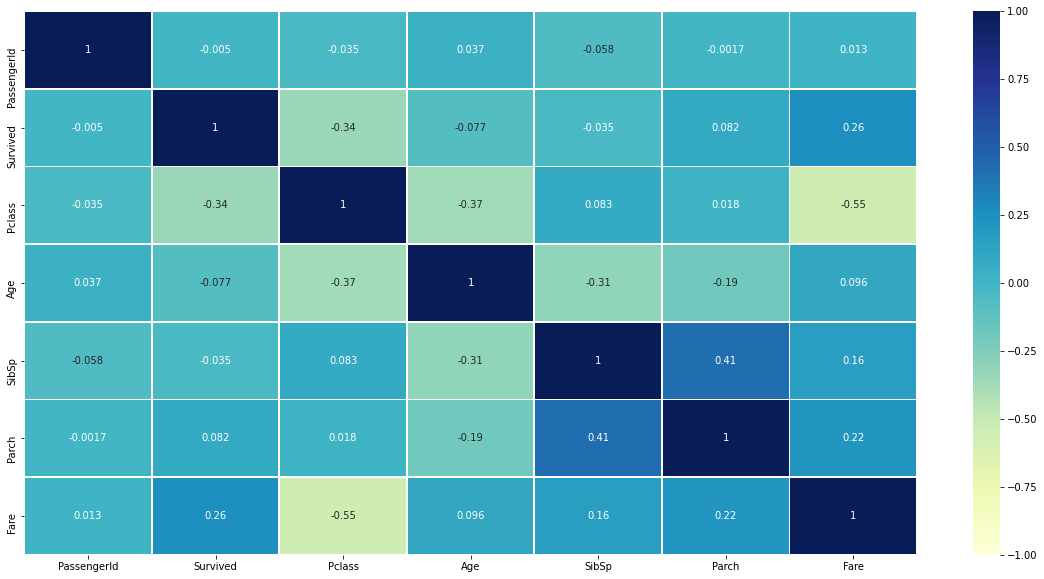

In [104]:
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [105]:
def check_missing(data):
  for column in data.columns:
      missing = column, data[column].isnull().sum()
      if missing[1] == 0: continue
      print(missing)

print("Test:")
check_missing(test)
print("Train:")
check_missing(train)

Test:
('Age', 86)
('Fare', 1)
('Cabin', 327)
Train:
('Age', 177)
('Cabin', 687)
('Embarked', 2)


In [106]:
del data,test,train
gc.collect()

NameError: ignored

**Feature engineering**

In [107]:
#get title from Name
def get_title(data):
  data['title'] = data['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
  data['title'].value_counts()

  top_titles = list(data['title'].value_counts().head(6).keys())

  title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
  data['title_norm'] = data['title'].map(title_norm)
  data['title_norm'].value_counts()

get_title(test)
get_title(train)

In [108]:
#group by title and  get mean of age
def age_mean_fillna(data):
    dict_mean_age_by_title = data.groupby('title_norm').agg(np.mean)['Age'].to_dict()
    data['age_mean'] = data.title_norm.map(dict_mean_age_by_title)
    train['Age'] = train['Age'].fillna(data['age_mean'])

age_mean_fillna(test)
age_mean_fillna(train)

In [109]:
data=pd.concat([train,test], ignore_index=True)
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,31.900667
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,23.298775
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,31.900667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,Mr,Mr,32.000000
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Dona,other,46.000000
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr,Mr,32.000000
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,Mr,Mr,32.000000


In [110]:
data = data.fillna(-1)

In [111]:
#remove empty Embarked
data = data[data['Embarked'] != -1]

In [112]:
#get name of cabin
data['Cabin2'] = data['Cabin'].astype(str).str[0]

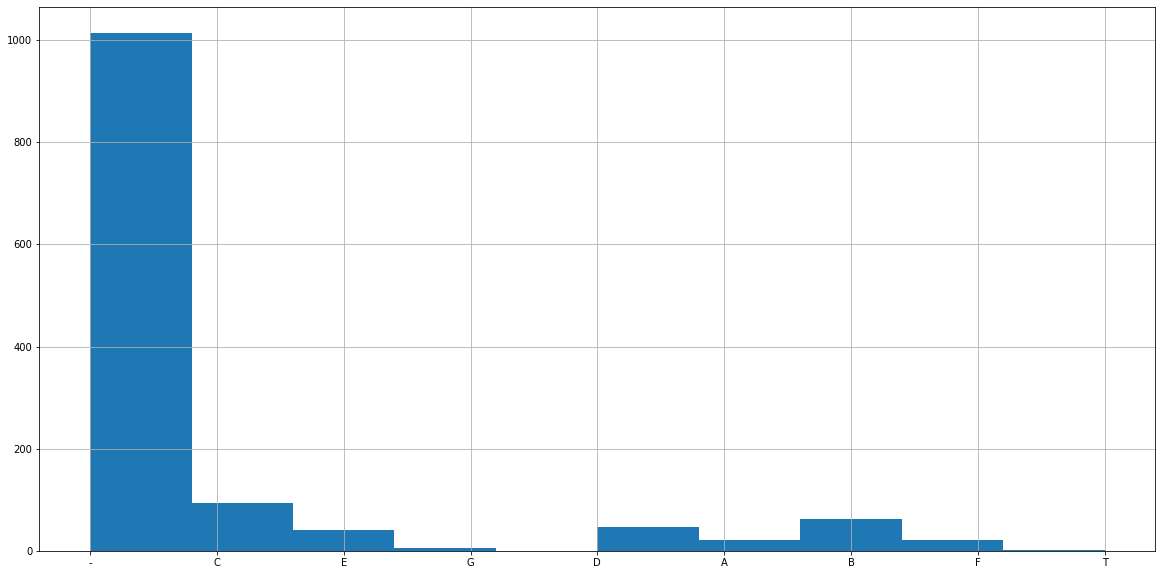

In [113]:
data.Cabin2.hist()

In [114]:
#data[data['Pclass']==3].Fare.hist()

In [115]:
#data.Fare.hist()

In [116]:
#sns.countplot(x='Pclass', hue = 'Survived',data = data)

In [117]:
#sns.countplot(x='Age', hue = 'Survived',data = train1)

In [118]:
data.SibSp.value_counts()

0    889
1    319
2     42
4     22
3     20
8      9
5      6
Name: SibSp, dtype: int64

In [119]:
#one-hot encoding
sex_feats = pd.get_dummies( data['Sex'] )
Pclass_feats = pd.get_dummies( data['Pclass'],prefix='Pclass' )
SibSp_feats = pd.get_dummies( data['SibSp'],prefix='SibSp' )
Parch_feats = pd.get_dummies( data['Parch'],prefix='Parch' )
Embarked_feats = pd.get_dummies( data['Embarked'],prefix='Embarked' )
data = pd.concat([data, sex_feats], axis=1)
data = pd.concat([data, Pclass_feats], axis=1)
#data = pd.concat([data, SibSp_feats], axis=1)
#data = pd.concat([data, Parch_feats], axis=1)
data = pd.concat([data, Embarked_feats], axis=1)

In [120]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1


In [121]:
data['title_norm_cat'] = data['title_norm'].factorize()[0]

In [122]:
#woman_3class
data.loc[(data['female'] == 1) & (data['Pclass'] == 3), 'woman_3class'] = 1
data.loc[data['woman_3class'].isnull(), 'woman_3class'] = 0
#woman_3class
data.loc[(data['male'] == 1) & (data['Pclass'] == 1), 'man_1class'] = 1
data.loc[data['man_1class'].isnull(), 'man_1class'] = 0

In [123]:
#concatenate sex+class
data['sex_class']=data.Sex +'_'+data.Pclass.astype(str)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_norm_cat,woman_3class,man_1class,sex_class
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0,1,0.0,0.0,female_1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1,2,1.0,0.0,female_3
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1,1,0.0,0.0,female_1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3


In [124]:
#is child or adult
data['child'] = data['age_mean'] < 18
data['adult'] = data['age_mean'] >= 18

In [125]:
#how big is family
data['family_size']   = data['SibSp'] + data['Parch'] + 1
data['family_single'] = data['family_size'] == 1
data['family_small']  = (data['family_size'] > 1) & (data['family_size'] < 5)
data['family_big']  = data['family_size'] > 4

In [126]:
#is mother
def is_mother(row):
    if row['Sex'] == 'male': return False
    if row['title_norm_cat'] == 'miss': return False
    if row['age_mean'] < 18: return False
    
    return True

data['is_mother'] = data.apply(is_mother, axis=1)
print(data['is_mother'].value_counts())

False    843
True     464
Name: is_mother, dtype: int64


In [127]:
#factorize new features
data['child_cat'] = data['child'].factorize()[0]
data['adult_cat'] = data['adult'].factorize()[0]
data['family_single'] = data['family_single'].factorize()[0]
data['family_small'] = data['family_small'].factorize()[0]
data['family_big'] = data['family_big'].factorize()[0]
data['is_mother_cat'] = data['is_mother'].factorize()[0]
data['sex_class_cat'] = data['sex_class'].factorize()[0]
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_norm_cat,woman_3class,man_1class,sex_class,child,adult,family_size,family_single,family_small,family_big,is_mother,child_cat,adult_cat,is_mother_cat,sex_class_cat
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,2,0,0,0,False,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1,2,1.0,0.0,female_3,False,True,1,1,1,0,True,0,0,1,2
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,1,1,1,0,False,0,0,0,0


In [128]:
#ranges of fare prices
data.loc[(data['Fare'] <= 50) , 'Fare1'] = 50
data.loc[(data['Fare'] > 50) & (data['Fare'] <=100), 'Fare1'] = 100
data.loc[(data['Fare'] > 100) & (data['Fare'] <=300), 'Fare1'] = 300
data.loc[(data['Fare'] > 300), 'Fare1'] = 'over300'
data.loc[data['Fare1'].isnull(), 'Fare1'] = 0
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_norm_cat,woman_3class,man_1class,sex_class,child,adult,family_size,family_single,family_small,family_big,is_mother,child_cat,adult_cat,is_mother_cat,sex_class_cat,Fare1
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,2,0,0,0,False,0,0,0,0,50
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1,2,1.0,0.0,female_3,False,True,1,1,1,0,True,0,0,1,2,50
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,1,1,1,0,False,0,0,0,0,50


In [129]:
#one hot encoding for fare and cabin
Fare_feats = pd.get_dummies( data['Fare1'],prefix='Fare' )
data = pd.concat([data, Fare_feats], axis=1)
Cabin_feats = pd.get_dummies( data['Cabin2'],prefix='Cabin' )
data = pd.concat([data, Cabin_feats], axis=1)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_norm_cat,woman_3class,man_1class,sex_class,child,adult,family_size,family_single,family_small,family_big,is_mother,child_cat,adult_cat,is_mother_cat,sex_class_cat,Fare1,Fare_50.0,Fare_100.0,Fare_300.0,Fare_over300,Cabin_-,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,2,0,0,0,False,0,0,0,0,50,1,0,0,0,1,0,0,0,0,0,0,0,0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100,0,1,0,0,0,0,0,1,0,0,0,0,0
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1,2,1.0,0.0,female_3,False,True,1,1,1,0,True,0,0,1,2,50,1,0,0,0,1,0,0,0,0,0,0,0,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100,0,1,0,0,0,0,0,1,0,0,0,0,0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,1,1,1,0,False,0,0,0,0,50,1,0,0,0,1,0,0,0,0,0,0,0,0


In [130]:
#length of ticket name
data["Ticket_len"]=data.Ticket.apply(lambda x:len(x))
data["Ticket_2letters"]=data.Ticket.apply(lambda x:x[:2])
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,age_mean,Cabin2,female,male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,title_norm_cat,woman_3class,man_1class,sex_class,child,adult,family_size,family_single,family_small,family_big,is_mother,child_cat,adult_cat,is_mother_cat,sex_class_cat,Fare1,Fare_50.0,Fare_100.0,Fare_300.0,Fare_over300,Cabin_-,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Ticket_len,Ticket_2letters
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,2,0,0,0,False,0,0,0,0,50,1,0,0,0,1,0,0,0,0,0,0,0,0,9,A/
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,35.310133,C,1,0,1,0,0,1,0,0,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100,0,1,0,0,0,0,0,1,0,0,0,0,0,8,PC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-1,S,Miss,Miss,23.298775,-,1,0,0,0,1,0,0,1,2,1.0,0.0,female_3,False,True,1,1,1,0,True,0,0,1,2,50,1,0,0,0,1,0,0,0,0,0,0,0,0,16,ST
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,35.310133,C,1,0,1,0,0,0,0,1,1,0.0,0.0,female_1,False,True,2,0,0,0,True,0,0,1,1,100,0,1,0,0,0,0,0,1,0,0,0,0,0,6,11
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-1,S,Mr,Mr,31.900667,-,0,1,0,0,1,0,0,1,0,0.0,0.0,male_3,False,True,1,1,1,0,False,0,0,0,0,50,1,0,0,0,1,0,0,0,0,0,0,0,0,6,37


**Models**

In [141]:
def get_feats(df, black_list=['Survived', 'PassengerId' ]):
  num_feats = df.select_dtypes(np.number).columns
  return [x for x in num_feats if x not in black_list]

feats = get_feats(data)
print(feats)

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'age_mean', 'female', 'male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'title_norm_cat', 'woman_3class', 'man_1class', 'family_size', 'family_single', 'family_small', 'family_big', 'child_cat', 'adult_cat', 'is_mother_cat', 'sex_class_cat', 'Fare_50.0', 'Fare_100.0', 'Fare_300.0', 'Fare_over300', 'Cabin_-', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Ticket_len']


In [132]:
# prepare to train
del train1, test1
gc.collect()

7206

In [133]:
#split dataset for test and train again
train1 = data[ data['Survived']!=(-1) ].copy()
test1 = data[ data['Survived']==(-1) ].copy()

In [134]:
#Random Forest Classifier
X = train1[feats].values
y = train1['Survived'].values
X_test = test1[feats]
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

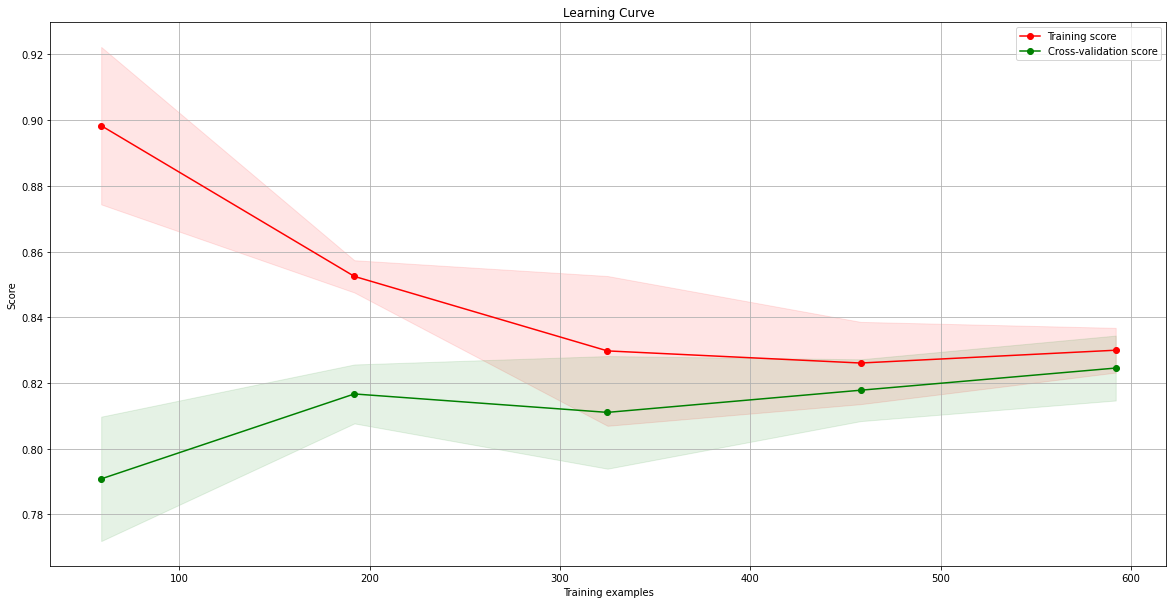

In [135]:
plot_learning_curve(model, X, y, cv=3);

In [136]:
feats = ['Fare', 'Pclass', 'title_norm_cat', 'family_size', 'Age', 'female', 'Cabin_-', 'Fare_100.0', 'age_mean', 'Cabin_C']

In [142]:
#XGBoost Classifier
X_test = test1[feats]
X = train1[feats].values
y = train1['Survived'].values
model_xgb = xgb.XGBClassifier(max_depth=2, n_estimators=70, random_state=0)
model_xgb.fit(X, y)
y_pred = model_xgb.predict(X)
mse = mean_squared_error(y, y_pred, squared=False)
print(mse)

0.37347364656614673


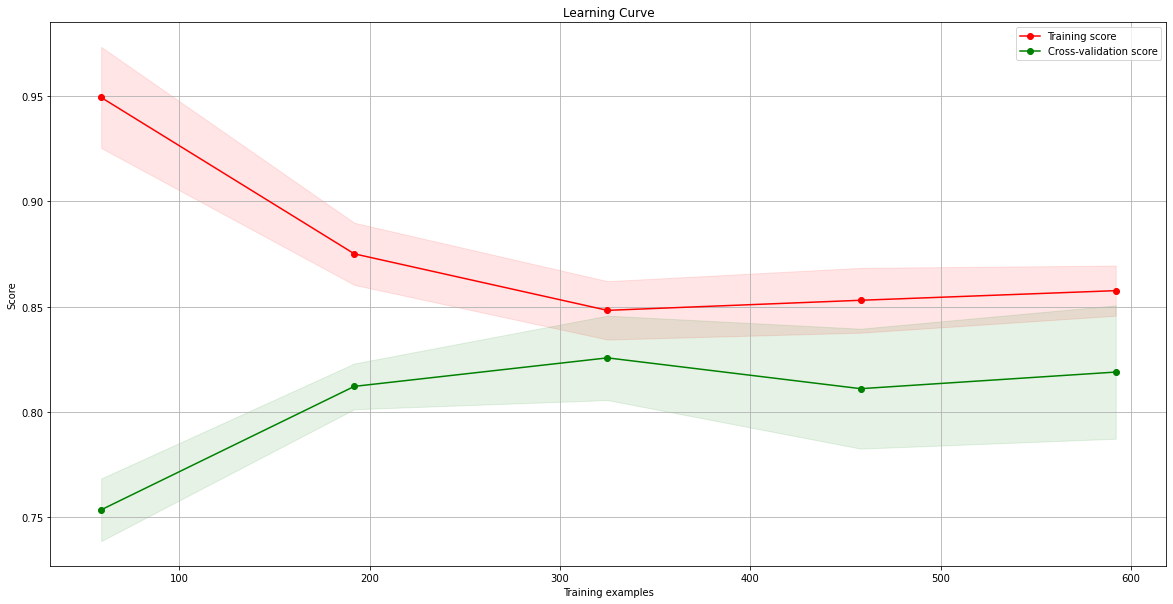

In [143]:
plot_learning_curve(model_xgb, X, y, cv=3);

In [144]:
def draw_feature_importances(model, features):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 5))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), model.feature_importances_[indices],
           color="b", align="center")
    plt.xticks(range(X.shape[1]), [ features[x] for x in indices])
    plt.xticks(rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

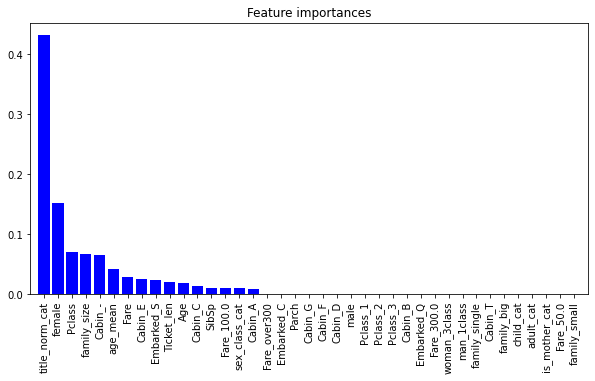

In [145]:
draw_feature_importances(model_xgb, feats)

In [80]:
import xgbfir
xgbfir.saveXgbFI(model_xgb, feature_names=feats, OutputXlsxFile="starter4.xls")

In [ ]:
pd.read_excel('/content/drive/MyDrive/Konkursy Kaggle/Titanic/starter4.xls','Interaction Depth 2').head(30) ["Interaction"].values

In [146]:
X_test = test1[feats]
y_pred = model_xgb.predict(test1[feats])
test1['Survived'] = y_pred
test1.Survived = test1["Survived"].astype(int)
test1[ ['PassengerId', 'Survived'] ].to_csv('c16_xgb5.csv', index=False)

ValueError: ignored

In [147]:
X_test = test1[feats].values
y_pred = model_xgb.predict(X_test)
test1['Survived'] = y_pred
test1.Survived = test1["Survived"].astype(int)
test1[ ['PassengerId', 'Survived'] ].to_csv('c_xgb_14.csv', index=False)

In [148]:
#Catboost Classifier
X_test = test1[feats].values
model_ctb = ctb.CatBoostClassifier(max_depth=3, n_estimators=100, random_state=0, verbose=False)
model_ctb.fit(X, y)
y_pred = model_ctb.predict(X)
mse = mean_squared_error(y, y_pred, squared=False)
print(mse)
predictions = model_ctb.predict(X_test)

0.38678973514378384


In [149]:
cross_val_score(model_ctb, X, y, scoring='accuracy', cv=3).mean()

0.8268040768040769

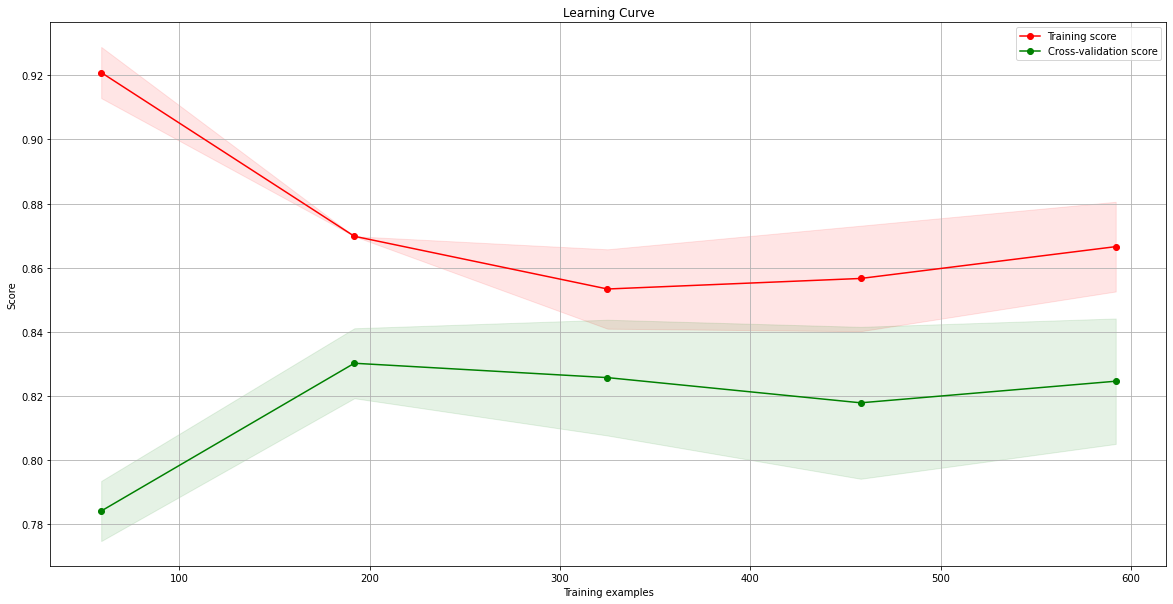

In [150]:

plot_learning_curve(model_ctb, X, y, cv=3);

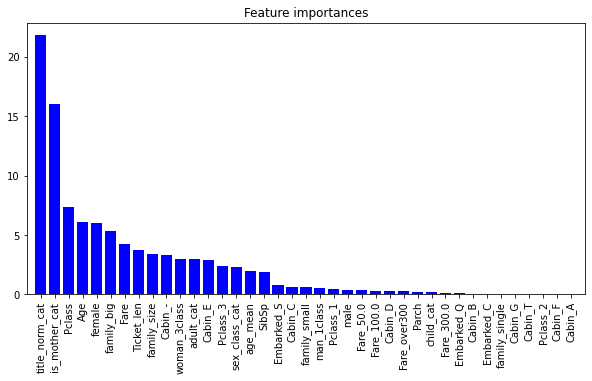

In [151]:
draw_feature_importances(model_ctb, feats)

In [ ]:
X_test = test1[feats].values
y_pred = model_ctb.predict(X_test)
test1['Survived'] = y_pred
test1.Survived = test1["Survived"].astype(int)
test1[ ['PassengerId', 'Survived'] ].to_csv('c16_ctb_9.csv', index=False)